In [1]:
"""
This code was written using chatGPT to a limited degree(~20%) -- practically, a Liliputian "Hello, world" script.

Sources: Official Gensim and Gensim communities, Dask documentation and Dask communities were used for review, along with a Brobdingnagian crawl of virtual-space(e.g. blogs, personal sites, stack exchange, etc.) which were 
on more occasions than not *several* years to the n^th degree old.

authors: alan hamm(pqn7)
         bertha(chatCDC)
         
apr 2024
"""

'\nThis code was written using chatGPT to a limited degree(~20%) -- practically, a Liliputian "Hello, world" script.\n\nSources: Official Gensim and Gensim communities, Dask documentation and Dask communities were used for review, along with a Brobdingnagian crawl of virtual-space(e.g. blogs, personal sites, stack exchange, etc.) which were \non more occasions than not *several* years to the n^th degree old.\n\nauthors: alan hamm(pqn7)\n         bertha(chatCDC)\n         \napr 2024\n'

## TopicFutures by Alan Hamm and Bertha

The provided script is a comprehensive Python program that utilizes several libraries to perform \
Latent Dirichlet Allocation (LDA) topic modeling on text data. The script includes functionality for \
data preprocessing, model training, evaluation, and visualization, as well as handling distributed computing with Dask.

At the beginning of the script, various libraries are imported including pyLDAvis.gensim for interactive topic model \
visualization, torch for deep learning operations and GPU acceleration, gensim for LDA modeling and coherence \
computation, and dask.distributed for parallel and distributed computing.\

The script sets up directory paths for logging, models, and visuals based on a given decade (DECADE). It checks if these \
directories exist and contain data; if they do, it archives their contents into a ZIP file before removing the old \
subdirectories. New directories are then created for the current run.

Logging configuration is established to record messages in a log file. Bokeh deprecation warnings are suppressed to avoid \
cluttering the output with irrelevant messages.

Parameters such as alpha (document-topic density) and beta (word-topic density) are defined as lists of possible values \
that will be used during LDA model training. These parameters influence the sparsity or density of topics in documents \
or words associated with topics.

A function named futures_create_lda_datasets() is defined to load data from a JSON file, shuffle it, split it into training \
and evaluation datasets based on a specified ratio (train_ratio), and return them as delayed objects ready for parallel processing with Dask.

Another function called save_model_and_log() takes care of saving trained LDA models along with their metadata into \
specified directories. It also logs this information into CSV files.

The core function train_model() performs the actual training of LDA models using Gensim's LdaModel. It processes text documents \
in batches to create dictionary mappings and trains an LDA model per batch. Model performance metrics like convergence score, \
perplexity score, and coherence score are calculated during this process.

The main execution block initializes a Dask cluster with specified worker configurations such as number of cores (CORES) and \
memory limits (RAM_MEMORY_LIMIT). A Dask client is created to manage tasks across workers. Training and evaluation datasets \
are prepared by calling the aforementioned functions. These datasets are scattered across workers for efficient parallel processing.

A series of nested loops iterate over combinations of topic numbers (n_topics), alpha values (alpha_values), \
and beta values (beta_values) to submit training tasks for both the training and evaluation datasets. These tasks are \
submitted to the Dask client, which distributes them across the available workers.

The script employs a progress bar from tqdm to visualize the progress of model creation and saving. It uses a batch processing \
approach where it waits for a certain number of futures (asynchronous task results) to complete before processing their \
results. If some futures do not complete within a specified timeout (TIMEOUT), they are recorded as failed and an attempt is \
made to retry them with an extended timeout (EXTENDED_TIMEOUT).

Once all models have been trained or reattempted, any remaining incomplete models' parameters are logged for review, indicating \
that these models did not successfully complete even after a second attempt.

Throughout the script, various utility functions such as os, json, random, csv, and others are used for file operations, \
data manipulation, random shuffling of data, and logging results in CSV format.

It's important to note that this script assumes certain global variables like DECADE, DATA_SOURCE, TRAIN_RATIO, CORES,\
THREADS_PER_CORE, etc., are defined elsewhere in the code or environment since they are referenced but not explicitly \
defined within the provided code snippet.

Overall, this script is designed for robust LDA topic modeling with extensive parameter exploration while leveraging distributed \
computing resources efficiently. It includes error handling mechanisms such as retries for failed tasks and comprehensive\
logging which aids in debugging and optimizing model performance.

The script is structured to handle large-scale topic modeling tasks in a distributed computing environment. After setting up\
 the Dask client and workers, it proceeds to create training and evaluation datasets from a specified data source (DATA_SOURCE) \
 using the futures_create_lda_datasets function. The resulting datasets are then scattered across the Dask cluster's workers \
 for parallel processing.

For model training, the script defines a train_model function that takes several parameters including the number of topics, \
alpha and beta values, and the dataset. This function processes text documents in batches, updating a global dictionary with \
each batch and training an LDA model using Gensim's LdaModel. It computes various performance metrics for each batch such as \
convergence score, perplexity score, and coherence score.

The main execution loop iterates over different combinations of model hyperparameters (number of topics, alpha values, beta values) \
and submits two sets of futures to the Dask client: one for training models on the training data (train_futures) and another \
for evaluating models on the evaluation data (eval_futures). These futures are monitored for completion, with progress tracked by a tqdm progress bar.

If any futures do not complete within the given timeout period (TIMEOUT), they are added to a list of failed model parameters \
(failed_model_params) for later analysis. The script includes functionality to retry processing these incomplete futures with \
an extended timeout (EXTENDED_TIMEOUT). Once all models have been processed or reattempted, any remaining incomplete models' \
parameters are logged using both standard output and a performance logger (perf_logger).

Finally, upon completion or failure of all tasks, the script closes the Dask client and provides an overview of which model parameters \
did not complete successfully after retries. This information can be used to diagnose potential issues in model training or resource \
allocation within the distributed computing setup.

In summary, this script is designed as an end-to-end solution for performing LDA topic modeling at scale. It incorporates best \
practices such as error handling through retries, logging important events and metrics for post-analysis, utilizing distributed\
 computing resources effectively via Dask, and providing user feedback through progress bars. Users looking to employ this script \
 should ensure they have set up their environment correctly with all necessary variables defined and have access to sufficient \
 computational resources managed by Dask.

In [2]:
import pyLDAvis.gensim  # Library for interactive topic model visualization
from tqdm import tqdm  # Creates progress bars to visualize the progress of loops or tasks
from gensim.models import LdaModel  # Implements LDA for topic modeling using the Gensim library
from gensim.corpora import Dictionary  # Represents a collection of text documents as a bag-of-words corpus
from gensim.models import CoherenceModel  # Computes coherence scores for topic models
import pyLDAvis
import IProgress 

import os  # Provides functions for interacting with the operating system, such as creating directories
import itertools  # Provides various functions for efficient iteration and combination of elements
import numpy as np  # Library for numerical computing in Python, used for array operations and calculations
from time import time, sleep # Measures the execution time of code snippets or functions
import pprint as pp  # Pretty-printing library, used here to format output in a readable way
import pandas as pd
import logging # Logging module for generating log messages
import sys # Provides access to some variables used or maintained by the interpreter and to functions that interact with the interpreter 
import shutil # High-level file operations such as copying and removal 
import zipfile # Provides tools to create, read, write, append, and list a ZIP file
from tqdm.notebook import tqdm  # Creates progress bars in Jupyter Notebook environment
from json import load
import random
import logging
import csv
import pprint as pp
from pandas.api.types import CategoricalDtype
from typing import Union, List
import math
from scipy import stats

from dask.distributed import as_completed
import dask   # Parallel computing library that scales Python workflows across multiple cores or machines 
from dask.distributed import Client, LocalCluster, wait   # Distributed computing framework that extends Dask functionality 
from dask.diagnostics import ProgressBar   # Visualizes progress of Dask computations
from dask.distributed import progress
from dask.delayed import Delayed # Decorator for creating delayed objects in Dask computations
#from dask.distributed import as_completed
from dask.bag import Bag
from dask import delayed
import dask.config
#from dask.distributed import wait
from dask.distributed import performance_report, wait, as_completed #,print
from distributed import get_worker
import gc



In [3]:
import logging
from datetime import datetime

DECADE_TO_PROCESS ='2010s'
LOG_DIRECTORY = f"C:/_harvester/data/lda-models/{DECADE_TO_PROCESS}_html/log/"
# Ensure the LOG_DIRECTORY exists
os.makedirs(LOG_DIRECTORY, exist_ok=True)

# Get the current date and time
now = datetime.now()

# Format the date and time as per your requirement
# Note: %w is the day of the week as a decimal (0=Sunday, 6=Saturday)
#       %Y is the four-digit year
#       %m is the two-digit month (01-12)
#       %H%M is the hour (00-23) followed by minute (00-59) in 24hr format
log_filename = now.strftime('log-%w-%m-%Y-%H%M.log')
LOGFILE = os.path.join(LOG_DIRECTORY,log_filename)

# Configure logging to write to a file with this name
logging.basicConfig(
    filename=LOGFILE,
    filemode='a',  # Append mode if you want to keep adding to the same file during the day
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO
)

# Now when you use logging.info(), logging.debug(), etc., it will write to that log file.

In [4]:
# Dask dashboard throws deprecation warnings w.r.t. Bokeh
import warnings
from bokeh.util.deprecation import BokehDeprecationWarning

# Disable Bokeh deprecation warnings
warnings.filterwarnings("ignore", category=BokehDeprecationWarning)
# Filter out the specific warning message
# Set the logging level for distributed.utils_perf to suppress warnings
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", module="distributed.utils_perf")

In [5]:

# Define the range of number of topics for LDA and step size
START_TOPICS = 50
END_TOPICS = 61
STEP_SIZE = 1

# define the decade that is being modelled 
DECADE = DECADE_TO_PROCESS

# In the case of this machine, since it has an Intel Core i9 processor with 8 physical cores (16 threads with Hyper-Threading), 
# it would be appropriate to set the number of workers in Dask Distributed LocalCluster to 8 or slightly lower to allow some CPU 
# resources for other tasks running on your system.
CORES = 10

THREADS_PER_CORE = 2

RAM_MEMORY_LIMIT = "10GB" 

# Specify the local directory path
DASK_DIR = '/_harvester/tmp-dask-out'

# specify the number of passes for Gensim LdaModel
PASSES = 15

# specify the number of iterations
ITERATIONS = 50

# specify the chunk size for LdaModel object
CHUNKSIZE = 750

# Number of documents to be iterated through for each update. 
# Set to 0 for batch learning, > 1 for online iterative learning.
UPDATE_EVERY = 3

# Log perplexity is estimated every that many updates. 
# Setting this to one slows down training by ~2x.
EVAL_EVERY = 5

# Constants for adaptive batching and retries
# Number of futures to process per iteration
BATCH_SIZE = 5 # number of documents


MAX_BATCH_SIZE = 25 # number of combinations
INCREASE_FACTOR = 1.2  # Increase batch size by 20% upon success
DECREASE_FACTOR = 0.1  # Decrease batch size by 10% upon failure or timeout
MAX_RETRIES = 5        # Maximum number of retries per task
BASE_WAIT_TIME = 1     # Base wait time in seconds for exponential backoff

# Load data from the JSON file
DATA_SOURCE = "C:/_harvester/data/tokenized-sentences/10s/tokenized_min_three_word-w-bigrams.json"
TRAIN_RATIO = 0.8

TIMEOUT = None #"90 minutes"

EXTENDED_TIMEOUT = None #"120 minutes"

CPU_UTILIZATION_THRESHOLD = 85 # ie 95%

# Enable serialization optimizations
dask.config.set(scheduler='distributed', serialize=True)
dask.config.set({'logging.distributed': 'error'})
dask.config.set({"distributed.scheduler.worker-ttl": None})
#dask.config.set({"distributed.scheduler.worker-ttl": None})

## Technical Documentation for LDA Model Data Management System
### Overview
The LDA Model Data Management System is designed to efficiently store and manage large volumes of text data and associated \
metadata generated by Latent Dirichlet Allocation (LDA) models. The system allows for quick access to text data based on \
queries of the metadata, facilitating dynamic generation of pyLDAvis objects or other topic analysis visualizations. 

### System Structure
The system comprises a top-level directory with several subdirectories designated for logs, visuals, metadata, and compressed \
text data. Each large body of text is stored as an individual ZIP file to save space, while metadata is stored in a Parquet \
file for efficient querying.

**Directory Structure**
* ROOT_DIR: The base directory containing all data related to the LDA models. \
* LOG_DIR: A subdirectory within ROOT_DIR that stores log files.\
* IMAGE_DIR: A subdirectory within ROOT_DIR that stores visualization files such as images or charts.\
* METADATA_DIR: A subdirectory within ROOT_DIR that stores metadata in a Parquet file.\
* TEXTS_ZIP_DIR: A subdirectory within ROOT_DIR where each text file is saved as an individual ZIP archive.\

**File Formats**
* **Parquet**: Used for storing metadata due to its efficiency in storage size and speed when querying columns.
* **ZIP**: Used for compressing individual text files to minimize disk space usage.

### Functions
**save_text_to_zip**(text_data) \
Saves a given string of text data into a ZIP file within the TEXTS_ZIP_DIR.
**Parameters**:
* text_data (str): The string content representing the body of text to be saved.
**Returns**:
* (str): The path to the created ZIP file containing the text data.

**add_model_data_to_metadata**(model_data) \
Adds new model data entries to the existing metadata Parquet file. If no Parquet file exists, it creates one.
**Parameters**:
* model_data (dict): A dictionary containing model-related information including texts and various scores like convergence, perplexity, coherence, etc.
**Side Effects**:
* Updates or creates a Parquet file at METADATA_DIR/metadata.parquet.

**get_text_from_zip**(zip_path)
Reads and returns the content of a specified text from its corresponding ZIP archive.
**Parameters**:
* zip_path (str): The path to the ZIP archive containing the text data.
**Returns**:
* (str): The text content extracted from the ZIP file.

**load_texts_for_analysis**(metadata_path, coherence_threshold=0.7) 
Loads metadata from a Parquet file and retrieves texts that meet specified criteria, such as a minimum coherence score.\
**Parameters**:
* metadata_path (str): The path to the metadata Parquet file.
* coherence_threshold (float, optional): The threshold for filtering records based on their coherence score. Defaults to 0.7.
**Returns**:
* (list of str): A list of text contents that meet the specified criteria.
    
### Usage
To use this system, follow these steps:

1. Ensure that all necessary directories (LOG_DIR, IMAGE_DIR, METADATA_DIR, TEXTS_ZIP_DIR) are created within the top-level directory (ROOT_DIR).
2. When new model data is generated, create a dictionary with keys corresponding to metadata fields and a 'text' key containing a list of large bodies of text.
3. Call add_model_data_to_metadata(new_model_data) to save the text data into individual ZIP files and update or create the metadata Parquet file with references to these ZIP files.
4. To retrieve texts for analysis based on metadata queries, call load_texts_for_analysis(parquet_file_path). You can specify a different coherence threshold if needed.
5. For any specific text retrieval based on its ZIP archive path, use get_text_from_zip(zip_path)

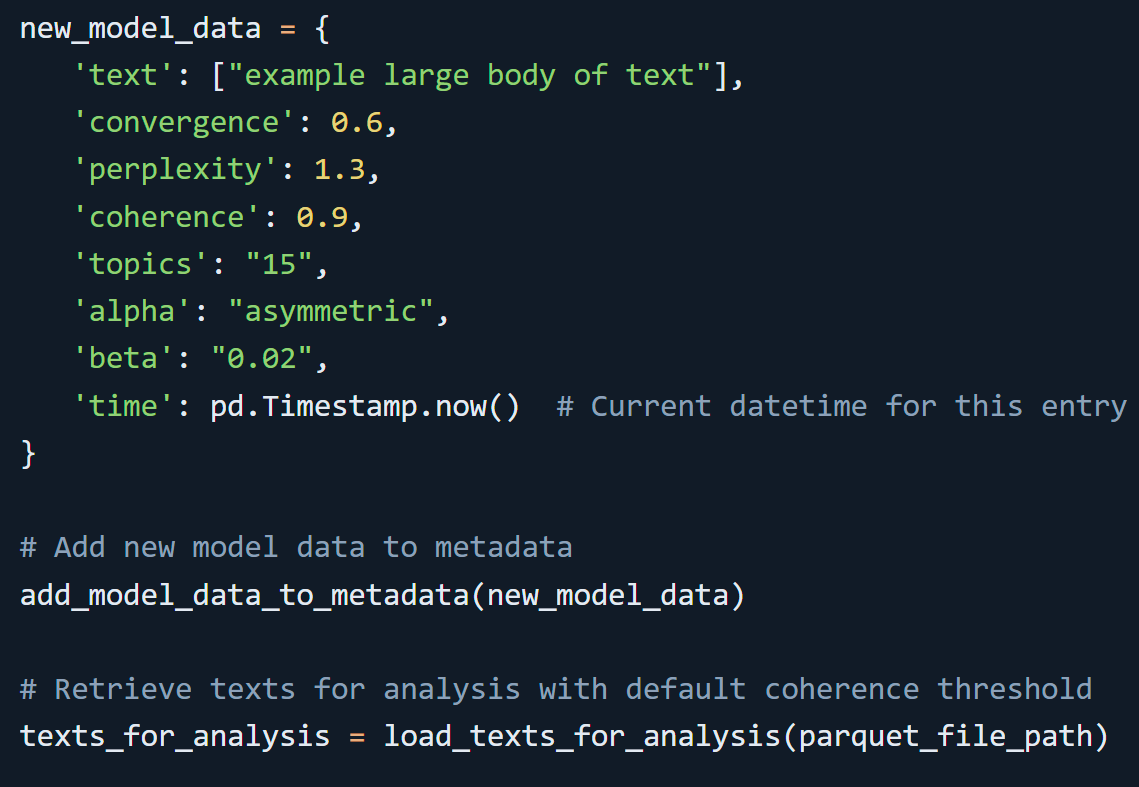

## Maintenance
The system requires minimal maintenance:
* Periodically check the available disk space in case the volume of stored texts grows significantly.
* Backup important data regularly, especially the Parquet file containing metadata and references to text files.
* Update directory paths and

In [6]:
import gc
def garbage_collection(development: bool, location: str):
    if development:
        # Enable debugging flags for leak statistics
        gc.set_debug(gc.DEBUG_LEAK)

    # Before calling collect, get a count of existing objects
    before = len(gc.get_objects())

    # Perform garbage collection
    collected = gc.collect()

    # After calling collect, get a new count of existing objects
    after = len(gc.get_objects())

    # Print or log before and after counts along with number collected
    logging.info(f"Garbage Collection at {location}:")
    logging.info(f"  Before GC: {before} objects")
    logging.info(f"  After GC: {after} objects")
    logging.info(f"  Collected: {collected} objects\n")


In [7]:
import os
import pandas as pd
import zipfile

# Define the top-level directory and subdirectories
DECADE = "2010s"  # Replace with your actual decade value
ROOT_DIR = f"C:/_harvester/data/lda-models/{DECADE}_html"
LOG_DIR = os.path.join(ROOT_DIR, "log")
IMAGE_DIR = os.path.join(ROOT_DIR, "visuals")
METADATA_DIR = os.path.join(ROOT_DIR, "metadata")
TEXTS_ZIP_DIR = os.path.join(ROOT_DIR, "texts_zip")

# Ensure that all necessary directories exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(METADATA_DIR, exist_ok=True)
os.makedirs(TEXTS_ZIP_DIR, exist_ok=True)

# Function to save text data to a zip file and return the path
def save_text_to_zip(text_data):
    # Generate a unique filename based on current timestamp
    timestamp_str = pd.Timestamp.now().strftime('%Y%m%d%H%M%S%f')
    text_zip_filename = f"text_{timestamp_str}.zip"
    
    # Write the text content to a zip file within TEXTS_ZIP_DIR
    zip_path = os.path.join(TEXTS_ZIP_DIR, text_zip_filename)
    with zipfile.ZipFile(zip_path, mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
        zf.writestr("text.txt", text_data)
    
    return zip_path

# Function to add new model data to metadata Parquet file
def add_model_data_to_metadata(model_data):
    #print("we are in the add_model_data_to_metadata method()")
    # Save large body of text to zip and update model_data reference
    texts_zipped = []
    for text_list in model_data['text']:
        combined_text = ' '.join([''.join(sent) for sent in text_list])  # Combine all sentences into one string
        zip_path = save_text_to_zip(combined_text)
        texts_zipped.append(zip_path)
    # Update model data with zipped paths
    model_data['text'] = texts_zipped

     # Ensure other fields are not lists, or if they are, they should have only one element per model
    for key, value in model_data.items():
        if isinstance(value, list) and key != 'text':
            assert len(value) == 1, f"Field {key} has multiple elements"
            model_data[key] = value[0]  # Unwrap single-element list
               
    # Define the expected data types for each column
    expected_dtypes = {
        'type': str, 
        'text': object,  # Use object dtype for lists of strings (file paths)
        'convergence': 'float64',
        'perplexity': 'float64',
        'coherence_mean': 'float64',
        'coherence_mode': 'float64',
        'coherence_median': 'float64',
        'coherence_std': 'float64',
        'topics': int,
        # Use pd.Categorical.dtype for categorical columns
        # Ensure alpha and beta are already categorical when passed into this function
        # They should not be wrapped again with CategoricalDtype here.
        'alpha_str': str,
        'n_alpha': 'float64',
        'beta_str': str,
        'n_beta': 'float64',
        # Enforce datetime type for time
        'time': 'datetime64[ns]',
    }   

    try:
        #df_new_metadata = pd.DataFrame({key: [value] if not isinstance(value, list) else value 
        #                                for key, value in model_data.items()}).astype(expected_dtypes)
        # Create a new DataFrame without enforcing dtypes initially
        df_new_metadata = pd.DataFrame({key: [value] if not isinstance(value, list) else value 
                                        for key, value in model_data.items()})
        
        # Apply type conversion selectively
        #for col_name in ['convergence', 'perplexity', 'coherence', 'n_beta', 'n_alpha']:
        for col_name in ['convergence', 'perplexity', 'n_beta', 'n_alpha']:
            df_new_metadata[col_name] = df_new_metadata[col_name].astype('float64')
            
        df_new_metadata['topics'] = df_new_metadata['topics'].astype(int)
        df_new_metadata['time'] = pd.to_datetime(df_new_metadata['time'])
    except ValueError as e:
        # Initialize an error message list
        error_messages = [f"Error converting model_data to DataFrame with enforced dtypes: {e}"]
        
        
        # Iterate over each item in model_data to collect its key, expected dtype, and actual value
        for key, value in model_data.items():
            expected_dtype = expected_dtypes.get(key, 'No expected dtype specified')
            actual_dtype = type(value).__name__
            error_messages.append(f"Column: {key}, Expected dtype: {expected_dtype}, Actual dtype: {actual_dtype}, Value: {value}")
        
        # Join all error messages into a single string
        full_error_message = "\n".join(error_messages)

        logging.error(full_error_message)

        raise ValueError("Data type mismatch encountered during DataFrame conversion. Detailed log available.")
    
    # Path to the metadata Parquet file
    parquet_file_path = os.path.join(METADATA_DIR, "metadata.parquet")
    
    # Check if the Parquet file already exists
    if os.path.exists(parquet_file_path): 
        # If it exists, read the existing metadata and append the new data 
        df_metadata = pd.read_parquet(parquet_file_path) 
        df_metadata = pd.concat([df_metadata, df_new_metadata], ignore_index=True) 
    else: 
        # If it doesn't exist, use the new data as the starting point 
        df_metadata = df_new_metadata

    # Save updated metadata DataFrame back to Parquet file
    df_metadata.to_parquet(parquet_file_path)
    #print("\nthis is the value of the parquet file")
    #print(df_metadata)


# Function to read a specific text from its zip file based on metadata query
def get_text_from_zip(zip_path): 
    with zipfile.ZipFile(zip_path, 'r') as zf: 
        return zf.read('text.txt').decode('utf-8')

# Example usage: Load metadata and retrieve texts based on some criteria
def load_texts_for_analysis(metadata_path, coherence_threshold=0.7): 
    # Load the metadata into a DataFrame 
    df_metadata = pd.read_parquet(metadata_path)

    # Filter metadata based on some criteria (e.g., coherence > threshold)
    filtered_metadata = df_metadata[df_metadata['coherence'] > coherence_threshold]

    # Retrieve and decompress associated texts from their zip files
    texts = [get_text_from_zip(zip_path) for zip_path in filtered_metadata['text']]

    return texts

In [8]:
PERFORMANCE_TRAIN_LOG = os.path.join(LOG_DIR, "train_model_performance.html")
# INCLUDE EVAL AND TRAINING DATA OUTPUT FILEPATHS HERE

In [9]:

num_topics = len(range(START_TOPICS, END_TOPICS + 1, STEP_SIZE))

# Calculate numeric_alpha for symmetric prior
numeric_symmetric = 1.0 / num_topics
# Calculate numeric_alpha for asymmetric prior (using best judgment)
numeric_asymmetric = 1.0 / (num_topics + np.sqrt(num_topics))
# Create the list with numeric values
numeric_alpha = [numeric_symmetric, numeric_asymmetric] + np.arange(0.01, 1, 0.3).tolist()
numeric_beta = [numeric_symmetric] + np.arange(0.01, 1, 0.3).tolist()


# The parameter `alpha` in Latent Dirichlet Allocation (LDA) represents the concentration parameter of the Dirichlet 
# prior distribution for the topic-document distribution.
# It controls the sparsity of the resulting document-topic distributions.

# A lower value of `alpha` leads to sparser distributions, meaning that each document is likely to be associated with fewer topics.
# Conversely, a higher value of `alpha` encourages documents to be associated with more topics, resulting in denser distributions.

# The choice of `alpha` affects the balance between topic diversity and document specificity in LDA modeling.
alpha_values = ['symmetric', 'asymmetric']
alpha_values += np.arange(0.01, 1, 0.3).tolist()

# In Latent Dirichlet Allocation (LDA) topic analysis, the beta parameter represents the concentration 
# parameter of the Dirichlet distribution used to model the topic-word distribution. It controls the 
# sparsity of topics by influencing how likely a given word is to be assigned to a particular topic.

# A higher value of beta encourages topics to have a more uniform distribution over words, resulting in more 
# general and diverse topics. Conversely, a lower value of beta promotes sparser topics with fewer dominant words.

# The choice of beta can impact the interpretability and granularity of the discovered topics in LDA.
beta_values = ['symmetric']
beta_values += np.arange(0.01, 1, 0.3).tolist()


In [10]:
from decimal import Decimal
def calculate_numeric_alpha(alpha_str, num_topics=num_topics):
    if alpha_str == 'symmetric':
        return Decimal('1.0') / num_topics
    elif alpha_str == 'asymmetric':
        return Decimal('1.0') / (num_topics + Decimal(num_topics).sqrt())
    else:
        # Use Decimal for arbitrary precision
        return Decimal(alpha_str)

def calculate_numeric_beta(beta_str, num_topics=num_topics):
    if beta_str == 'symmetric':
        return Decimal('1.0') / num_topics
    else:
        # Use Decimal for arbitrary precision
        return Decimal(beta_str)

def validate_alpha_beta(alpha_str, beta_str):
    valid_strings = ['symmetric', 'asymmetric']
    if isinstance(alpha_str, str) and alpha_str not in valid_strings:
        logging.error(f"Invalid alpha_str value: {alpha_str}. Must be 'symmetric', 'asymmetric', or a numeric value.")
        raise ValueError(f"Invalid alpha_str value: {alpha_str}. Must be 'symmetric', 'asymmetric', or a numeric value.")
    if isinstance(beta_str, str) and beta_str not in valid_strings:
        logging.error(f"Invalid beta_str value: {beta_str}. Must be 'symmetric', or a numeric value.")
        raise ValueError(f"Invalid beta_str value: {beta_str}. Must be 'symmetric', or a numeric value.")

In [11]:
"""
!!! DO NOT EXECUTE THIS CELL OR ANY CELL USING IT WITHOUT FIRSST
!!! UPDATING THE OUTPUT FILEPATH FOR THE TRAINING AND EVAL DATA
"""
import os
from json import load
import random

def get_num_records(filename):
    with open(filename, 'r') as jsonfile:
        data = load(jsonfile)
        data = data
        num_samples = len(data)  # Count the total number of samples
    return num_samples

import os
import json
from random import shuffle

def load(jsonfile):
    return json.load(jsonfile)

def futures_create_lda_datasets(filename, train_ratio, batch_size):
    with open(filename, 'r') as jsonfile:
        data = load(jsonfile)
        data = data[:5000]
        num_samples = len(data[:5000])  # Count the total number of samples
        
        # Shuffle data indices since we can't shuffle actual lines in a file efficiently
        indices = list(range(num_samples))
        shuffle(indices)
        
        num_train_samples = int(num_samples * train_ratio)  # Calculate number of samples for training
        
        cumulative_count = 0  # Initialize cumulative count
        # Initialize counters for train and eval datasets
        train_count = 0
        eval_count = num_train_samples
        
        # Yield batches as dictionaries for both train and eval datasets along with their sample count
        while train_count < num_train_samples or eval_count < num_samples:
            if train_count < num_train_samples:
                # Yield a training batch
                train_indices_batch = indices[train_count:train_count + batch_size]
                train_data_batch = [data[idx] for idx in train_indices_batch]
                yield {
                    'type': 'train',
                    'data': train_data_batch,
                    'indices_batch': train_indices_batch,
                    'cumulative_count': train_count,
                    'num_samples': num_train_samples,
                    'whole_dataset': data[:num_train_samples]
                }
                train_count += len(train_data_batch)
                cumulative_count += train_count
            
            if eval_count < num_samples or train_count >= num_train_samples:
                # Yield an evaluation batch
                #print("we are in the method to create the futures trying to create the eval data.")
                #print(f"the eval count is {eval_count} and the train count is {train_count} and the num train samples is {num_train_samples}")
                eval_indices_batch = indices[eval_count:eval_count + batch_size]
                eval_data_batch = [data[idx] for idx in eval_indices_batch]
                yield {
                    'type': 'eval',
                    'data': eval_data_batch,
                    'indices_batch': eval_indices_batch,
                    'cumulative_count': eval_count - num_train_samples,
                    'num_samples': num_samples - num_train_samples,
                    'whole_dataset': data[num_train_samples:]
                }
                eval_count += len(eval_data_batch)
                cumulative_count += eval_count
                
        #garbage_collection(False,'futures_create_lda_datasets(...)')

In [12]:
# create training and eval dictionaries used in train_model(...) method
def create_dictionary(filename):
    with open(filename, 'r') as jsonfile:
        data = load(jsonfile)
        num_samples = len(data)  # Count the total number of samples
        logging.info(f"The min five with bigrams has {num_samples} sentences")
        return data
#minfivedict = create_dictionary(DATA_SOURCE)

In [13]:
def create_vis(ldaModel, filename, corpus, dictionary):
    LOGFILE = os.path.join(IMAGE_DIR,filename)

    pyLDAvis.disable_notebook()
    vis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)

    pyLDAvis.save_html(vis, LOGFILE)


In [14]:
def train_model(n_topics: int, alpha_str: list, beta_str: list, data: list, train_eval: str, chunksize=BATCH_SIZE):
        models_data = []
        coherehce_score_list = []
        corpus_batch = []
        zipped_texts = []
        #print("this is an investigation into the full datafile")
        #pp.pprint(full_datafile)
        # Convert the Delayed object to a Dask Bag and compute it to get the actual data
        try:
            streaming_documents = dask.compute(*data)
            #print("these are the streaming documents")
            #print(streaming_documents)
            #garbage_collection(False, 'train_model(): streaming_documents = dask.compute(*data)')
        except Exception as e:
            logging.error(f"Error computing streaming_documents data: {e}")
            raise
        #print(f"This is the dtype for 'streaming_documents' {type(streaming_documents)}.\n")  # Should output <class 'tuple'>
        #print(streaming_documents[0][0])     # Check the first element to see if it's as expected

        # Select documents for current batch
        batch_documents = streaming_documents
        
        # Create a new Gensim Dictionary for the current batch
        try:
            dictionary_batch = Dictionary(list(batch_documents))
            #print("The dictionary was cretaed.")
        except TypeError:
            print("Error: The data structure is not correct.")
        #else:
        #    print("Dictionary created successfully!")

        #if isinstance(batch_documents[0], list) and all(isinstance(doc, list) for doc in batch_documents[0]):
        #bow_out = dictionary_batch.doc2bow(batch_documents[0])
        flattened_batch = [item for sublist in batch_documents for item in sublist]
        #bow_out = dictionary_batch.doc2bow(flattened_batch)
        #else:
        #    raise ValueError(f"Expected batch_documents[0] to be a list of token lists. Instead received {type(batch_documents[0])} with value {batch_documents[0]}\n")

        # Iterate over each document in batch_documents
        number_of_documents = 0
        for doc_tokens in batch_documents:
            # Create the bag-of-words representation for the current document using the dictionary
            bow_out = dictionary_batch.doc2bow(doc_tokens)
            # Append this representation to the corpus
            corpus_batch.append(bow_out)
            number_of_documents += 1
        logging.info(f"There was a total of {number_of_documents} documents added to the corpus_batch.")
            
        #logger.info(f"HERE IS THE TEXT for corpus_batch using LOGGER: {corpus_batch}\n")
        #except Exception as e:
        #    logger.error(f"An unexpected error occurred with BOW_OUT: {e}")
                
        #if isinstance(texts_out[0], list):
        #    texts_batch.append(texts_out[0])
        #else:
        #    logging.error("Expected texts_out to be a list of strings (words), got:", texts_out[0])
        #    raise ValueError("Expected texts_out to be a list of strings (words), got:", texts_out[0])
                
        n_alpha = calculate_numeric_alpha(alpha_str)
        n_beta = calculate_numeric_beta(beta_str)
        try:
            #logger.info("we are inside the try block at the beginning")
            lda_model_gensim = LdaModel(corpus=corpus_batch,
                                                id2word=dictionary_batch,
                                                num_topics=n_topics,
                                                alpha= float(n_alpha),
                                                eta= float(n_beta),
                                                random_state=75,
                                                passes=PASSES,
                                                iterations=ITERATIONS,
                                                update_every=UPDATE_EVERY,
                                                eval_every=EVAL_EVERY,
                                                chunksize=CHUNKSIZE,
                                                per_word_topics=True)
            #logger.info("we are inside the try block after the constructor")

                                          
        except Exception as e:
            logging.error(f"An error occurred during LDA model training: {e}")
            raise  # Optionally re-raise the exception if you want it to propagate further      

        #coherence_score = None  # Assign a default value
        with np.errstate(divide='ignore', invalid='ignore'):
            try:
                #coherence_model_lda = CoherenceModel(model=lda_model_gensim, processes=math.floor(CORES*(2/3)), dictionary=dictionary_batch, texts=batch_documents[0], coherence='c_v') 
                coherence_model_lda = CoherenceModel(model=lda_model_gensim, processes=math.floor(CORES*(1/3)), dictionary=dictionary_batch, texts=batch_documents, coherence='c_v') 
                coherence_score = coherence_model_lda.get_coherence()
                coherehce_score_list.append(coherence_score)
            except Exception as e:
                logging.error("there was an issue calculating coherence score. value 'Inf' has been assigned.\n")
                coherence_score = float('inf')
                coherehce_score_list.append(coherence_score)
                #sys.exit()

        try:
            convergence_score = lda_model_gensim.bound(corpus_batch)
        except Exception as e:
            logging.error("there was an issue calculating convergence score. value 'Inf' has been assigned.\n")
            convergence_score = float('inf')
                    
        try:
            perplexity_score = lda_model_gensim.log_perplexity(corpus_batch)
        except RuntimeWarning as e:
            logging.info("there was an issue calculating perplexity score. value 'Inf' has been assigned.\n")
            perplexity_score = float('inf')
            #sys.exit()
        
       #print(f"type: {train_eval}, coherence: {coherence_score}, n_topics: {n_topics}, n_alpha: {n_alpha}, alpha_str: {alpha_str}, n_beta: {n_beta}, beta_str: {beta_str}")
        logging.info(f"type: {train_eval}, coherence: {coherence_score}, n_topics: {n_topics}, n_alpha: {n_alpha}, alpha_str: {alpha_str}, n_beta: {n_beta}, beta_str: {beta_str}\n      batch documents: {batch_documents}\n")     
        """
        for doc_index, texts in enumerate(batch_documents):
            combined_text = ''
            combined_text_dict = {}

            for word_index, word in enumerate(texts):
                combined_text += (' ' + word) if combined_text else word
                if word_index not in combined_text_dict.keys():
                    #print("this is the combined_text", combined_text)
                    combined_text_dict[word_index] = combined_text

        my_string = " ".join(str(element) for element in batch_documents)
        #print("this is the concatenated sent", my_string)
        """
        string_result = ' '.join(map(str, flattened_batch))
        zip_path = save_text_to_zip(string_result)
        zipped_texts.append(zip_path)
        #print(f"we are claculating the coherence value using combined_text at {word_index}: {combined_text_dict[word_index]}")


        # Convert numeric beta value to string if necessary
        if isinstance(beta_str, float):
            beta_str = str(beta_str)
                
        # Convert numeric alpha value to string if necessary
        if isinstance(alpha_str, float):
            alpha_str = str(alpha_str)

        current_increment_data = {
                'type': train_eval, 
                'text': [zipped_texts],
                'convergence': convergence_score,
                'perplexity': perplexity_score,
                'coherence_mean': np.mean(coherehce_score_list),
                'coherence_mode': stats.mode(coherehce_score_list),
                'coherence_median': np.median(coherehce_score_list),
                'coherence_std': np.std(coherehce_score_list),
                'topics': n_topics,
                'alpha_str': [alpha_str],
                'n_alpha': calculate_numeric_alpha(alpha_str),
                'beta_str': [beta_str],
                'n_beta': calculate_numeric_beta(beta_str),
                'time': pd.to_datetime('now')
        }

        models_data.append(current_increment_data)
        #garbage_collection(False, 'train_model(): convergence and perplexity score calculations')

        return models_data


In [15]:
# Define a delayed version of the train_model function
@dask.delayed
def delayed_train_model(n_topics, alpha_value, beta_value, scattered_data, train_eval_type):
    # Call the train_model function here
    train_model(n_topics, alpha_value, beta_value, scattered_data, train_eval_type)

In [16]:
"""
                    - The `process_completed_future` function is called when all futures in a batch complete within the specified timeout. It 
                        can be used to continue with your program using both completed training and evaluation futures.
                    - The `retry_processing` function is called when there are incomplete futures after iterating through a batch of 
                        data. It can be used to retry processing with those incomplete futures.
                    - The code checks if there are any remaining futures in the lists after completing all iterations. If so, it 
                        waits for them to complete and handles them accordingly.
"""

# List to store parameters of models that failed to complete even after a retry
failed_model_params = []

# Mapping from futures to their corresponding parameters (n_topics, alpha_value, beta_value)
future_to_params = {}
def process_completed_futures(completed_train_futures, completed_eval_futures, log_dir):
    print("we are in the process_completed_futures method()")
    # Process training futures
    for future in completed_train_futures:
        try:
            # Retrieve the result of the training future
            #if isinstance(future.result(), list):
            models_data = future.result()  # This should be a list of dictionaries
            if not isinstance(models_data, list):
                models_data = list(future.result())  # This should be a list of dictionaries
            logging.info(f"this is the value of the TRAIN MODELS_DATA within the process_completed method: {models_data}")
            #else:
            #    models_data = list(future.result())
            #print("this is the value of models data:", models_data)
            
        except TypeError as e:
            logging.error(f"Error occurred during training: {e}")
            sys.exit()
        else:
            # Iterate over each model's data and save it
            for model_data in models_data:
                # Check if models_data is a non-empty list before iterating
                if isinstance(models_data, list) and models_data:
                    for model_data in models_data:
                        logging.info(f"this is the value of model TRAIN data: {model_data}")
                        #save_model_and_log(model_data=model_data, log_dir=log_dir, train_or_eval=True)
                        add_model_data_to_metadata(model_data)
                else:
                    # Handle the case where models_data is not as expected
                    logging.info(f"Received unexpected result from TRAIN future: {models_data}")

    # Process evaluation futures
    for future in completed_eval_futures:
        try:
            # Retrieve the result of the training future
            #if isinstance(future.result(), list):
            models_data = future.result()  # This should be a list of dictionaries
            if not isinstance(models_data, list):
                models_data = list(future.result())  # This should be a list of dictionaries
            logging.info(f"this is the value of the EVAL MODELS_DATA within the process_completed method: {models_data}")
            #else:
            #    models_data = list(future.result())
            #print("this is the value of models data:", models_data)
        except TypeError as e:
            logging.error(f"Error occurred during evaluation: {e}")
            sys.exit()
        else:
            # Iterate over each model's data and save it
            for model_data in models_data:
                # Check if models_data is a non-empty list before iterating
                if isinstance(models_data, list) and models_data:
                    for model_data in models_data:
                        logging.info(f"this is the value of model EVAL data: {model_data}")
                        #save_model_and_log(model_data=model_data, log_dir=log_dir, train_or_eval=False)
                        add_model_data_to_metadata(model_data)
                else:
                    # Handle the case where models_data is not as expected
                    logging.info(f"Received unexpected result from EVAL future: {models_data}")
                
    #garbage_collection(False, 'process_completed_futures(...)')

            
# Function to retry processing with incomplete futures
def retry_processing(incomplete_train_futures, incomplete_eval_futures, timeout):
    #print("we are in the retry_processing method()")
    # Retry processing with incomplete futures using an extended timeout
    done, not_done = wait(incomplete_train_futures + incomplete_eval_futures, timeout=timeout)
    
    # Process completed ones
    process_completed_futures([f for f in done if f in incomplete_train_futures],
                              [f for f in done if f in incomplete_eval_futures],
                              LOG_DIR)
    
    # Record parameters of still incomplete futures for later review
    failed_model_params.extend(future_to_params[future] for future in not_done)

    #garbage_collection(False, 'retry_processing(...)')

In [17]:
# Dictionary to keep track of retries for each task
task_retries = {}

# Function to perform exponential backoff
def exponential_backoff(attempt):
    return BASE_WAIT_TIME * (2 ** attempt)

# Function to handle failed futures and potentially retry them
def handle_failed_future(future, future_to_params, train_futures, eval_futures, client):
    print("We are in the handle_failed_future() method.\n")
    params = future_to_params[future]
    attempt = task_retries.get(params, 0)
    
    if attempt < MAX_RETRIES:
        print(f"Retrying task {params} (attempt {attempt + 1}/{MAX_RETRIES})")
        wait_time = exponential_backoff(attempt)
        sleep(wait_time)  
        
        task_retries[params] = attempt + 1
        
        new_future_train = client.submit(train_model, *params)
        new_future_eval = client.submit(train_model, *params)
        
        future_to_params[new_future_train] = params
        future_to_params[new_future_eval] = params
        
        train_futures.append(new_future_train)
        eval_futures.append(new_future_eval)
    else:
        print(f"Task {params} failed after {MAX_RETRIES} attempts. No more retries.")

    #garbage_collection(False,'handle_failed_future')

## Asynchronous Execution as said by Brunhilda:

Asynchronous execution allows you to execute tasks concurrently, without waiting for each task to complete before moving on \
to the next one. This can improve the overall efficiency and speed of your program.

In the given code snippet, asynchronous execution is achieved using Dask's as_completed function. This function takes a list \
of futures (representing tasks) and returns an iterator that yields futures as they complete.

Here's how it works:

&nbsp;&nbsp;&nbsp;&nbsp;(1) First, you submit all your training and evaluation tasks using client.submit(). These tasks are represented by futures. \
&nbsp;&nbsp;&nbsp;&nbsp;(2) You add callback functions (callback_train and callback_eval) to these futures using the add_done_callback() method. These callbacks will be executed when their respective futures complete.\
&nbsp;&nbsp;&nbsp;&nbsp;(3) You create two lists, train_futures and eval_futures, to store the futures for training and evaluation models respectively.\
&nbsp;&nbsp;&nbsp;&nbsp;(4) After submitting all the tasks, you enter a loop where you iterate over the range of values for n_topics, alpha_value, and beta_value.\
&nbsp;&nbsp;&nbsp;&nbsp;(5) Inside this loop, you submit the training and evaluation tasks for each combination of parameters using client.submit(). These new futures are added to their respective lists.\
&nbsp;&nbsp;&nbsp;&nbsp;(6) Next, you use the as_completed function to iterate over both lists of futures (train_futures and eval_futures). This function returns an iterator that yields completed futures as they become available.\
&nbsp;&nbsp;&nbsp;&nbsp;(7) As each future completes, its associated callback function (callback_train or callback_eval) is executed.\
&nbsp;&nbsp;&nbsp;&nbsp;(8) Inside these callback functions, you retrieve the result of the completed future using .result(). You can then save the trained or evaluated model using the provided save_model_and_log function.\
&nbsp;&nbsp;&nbsp;&nbsp;(9) The loop continues until all combinations of parameters have been processed.\
&nbsp;&nbsp;&nbsp;&nbsp;(10) Finally, after all models have been saved and logged, you close the Dask client. 

By utilizing asynchronous execution with Dask's as_completed, your program can process multiple tasks concurrently while still ensuring that each model is saved once its associated task has completed.

In [18]:
from tqdm import tqdm
if __name__=="__main__":

    cluster = LocalCluster(
            n_workers=CORES,
            threads_per_worker=THREADS_PER_CORE,
            processes=False,
            memory_limit=RAM_MEMORY_LIMIT,
            local_directory=DASK_DIR,
            #dashboard_address=None,
            dashboard_address=":8787",
            protocol="tcp",
    )


    # Create the distributed client
    client = Client(cluster)

    client.cluster.adapt(minimum=CORES, maximum=14)
    
    # Get information about workers from scheduler
    workers_info = client.scheduler_info()["workers"]

    # Iterate over workers and set their memory limits
    for worker_id, worker_info in workers_info.items():
        worker_info["memory_limit"] = RAM_MEMORY_LIMIT

    # Verify that memory limits have been set correctly
    #for worker_id, worker_info in workers_info.items():
    #    print(f"Worker {worker_id}: Memory Limit - {worker_info['memory_limit']}")

    # Check if the Dask client is connected to a scheduler:
    if client.status == "running":
        print("Dask client is connected to a scheduler.")
        # Scatter the embedding vectors across Dask workers
    else:
        print("Dask client is not connected to a scheduler.")
        print("The system is shutting down.")
        client.close()
        cluster.close()
        sys.exit()

    # Check if Dask workers are running:
    if len(client.scheduler_info()["workers"]) > 0:
        print("Dask workers are running.")
    else:
        print("No Dask workers are running.")
        print("The system is shutting down.")
        client.close()
        cluster.close()
        sys.exit()

    print("Creating training and evaluation samples...")
    
    started = time()
    
    scattered_train_data_futures = []
    scattered_eval_data_futures = []

    total_num_samples = get_num_records(DATA_SOURCE)

    whole_train_dataset = None
    whole_eval_dataset = None

    with tqdm(total=total_num_samples) as pbar:
        # Process each batch as it is generated
        for batch_info in futures_create_lda_datasets(DATA_SOURCE, TRAIN_RATIO, BATCH_SIZE):
            if batch_info['type'] == 'train':
                # Handle training data
                #print("We are inside the IF/ELSE block for producing TRAIN scatter.")
                try:
                    scattered_future = client.scatter(batch_info['data'])
                    scattered_train_data_futures.append(scattered_future)
                except Exception as e:
                    print("there was an issue with creating the TRAIN scattered_future list")
                
                if whole_train_dataset is None:
                    whole_train_dataset = batch_info['whole_dataset']
            elif batch_info['type'] == 'eval':
                # Handle evaluation data
                #print("We are inside the IF/ELSE block for producing EVAL scatter.")
                try:
                    scattered_future = client.scatter(batch_info['data'])
                    scattered_eval_data_futures.append(scattered_future)
                except Exception as e:
                    print("there was an issue with creating the EVAL scattererd_future list.")
                
                if whole_eval_dataset is None:
                    whole_eval_dataset = batch_info['whole_dataset']

            # Update the progress bar with the cumulative count of samples processed
            #pbar.update(batch_info['cumulative_count'] - pbar.n)
            pbar.update(len(batch_info['data']))

        pbar.close()  # Ensure closure of the progress bar

    print(f"Completed creation of training and evaluation samples in {round((time() - started)/60,2)} minutes.\n")
   
    print("Data scatter complete...\n")
    #garbage_collection(False, 'scattering training and eval data')


    train_futures = []  # List to store futures for training
    eval_futures = []  # List to store futures for evaluation
   
    num_topics = len(range(START_TOPICS, END_TOPICS + 1, STEP_SIZE))
    num_alpha_values = len(alpha_values)
    num_beta_values = len(beta_values)

    TOTAL_MODELS = (num_topics * num_alpha_values * num_beta_values) * 2

    progress_bar = tqdm(total=TOTAL_MODELS, desc="Creating and saving models")

    train_eval = ['eval', 'train']

    # Create a list of all combinations of n_topics, alpha_value, beta_value, and train_eval
    combinations = list(itertools.product(range(START_TOPICS, END_TOPICS + 1, STEP_SIZE), alpha_values, beta_values, train_eval))

    # Separate the combinations into two lists based on 'train' and 'eval'
    train_combinations = [combo for combo in combinations if combo[-1] == 'train']
    eval_combinations = [combo for combo in combinations if combo[-1] == 'eval']

    # Calculate the sample size for each category
    sample_size = min(len(train_combinations), len(eval_combinations))

    # Select random combinations from each category
    random_train_combinations = random.sample(train_combinations, sample_size)
    random_eval_combinations = random.sample(eval_combinations, sample_size)

    # Combine the randomly selected train and eval combinations
    random_combinations = random_eval_combinations+ random_train_combinations
    sample_size = max(1, int(len(combinations) * 0.375))

    # Select random_combinations conditionally
    random_combinations = random.sample(combinations, sample_size) if sample_size < len(combinations) else combinations
    print(f"The random sample contains {len(random_combinations)}")

    # Determine which combinations were not drawn by using set difference
    undrawn_combinations = list(set(combinations) - set(random_combinations))

    print(f"this leaves {len(undrawn_combinations)} remaining\n")

    # Create empty lists to store all future objects for training and evaluation
    all_train_futures = []
    all_eval_futures = []
    
    # Iterate over the combinations and submit tasks
    for n_topics, alpha_value, beta_value, train_eval_type in random_combinations:

        # determine if throttling is needed
        logging.info("\nEvaluating if adaptive throttling is necessary (method exponential backoff)...")
        started, throttle_attempt = time(), 0

        while throttle_attempt < MAX_RETRIES and not all(worker['metrics']['cpu'] < CPU_UTILIZATION_THRESHOLD for worker in client.scheduler_info()['workers'].values()):
            logging.info(f"Adaptive throttling (attempt {throttle_attempt} of {MAX_RETRIES-1}")
            #logging.info(f"for LdaModel hyperparameters combination -- type: {train_eval_type}, topic: {n_topics}, ALPHA: {alpha_value} and ETA {beta_value}")
            sleep(exponential_backoff(throttle_attempt))
            throttle_attempt += 1

        logging.info(f"Adaptive throttling (method: exponential backoff) {'completed in {:.2f} seconds'.format(time() - started) if throttle_attempt else 'was not necessary...'}\n")

        logging.info(f"for LdaModel hyperparameters combination -- type: {train_eval_type}, topic: {n_topics}, ALPHA: {alpha_value} and ETA {beta_value}")
        # Submit a future for each scattered data object in the training list
        #if train_eval_type == 'train':
        # Submit a future for each scattered data object in the training list
        for scattered_data in scattered_train_data_futures:
            future = client.submit(train_model, n_topics, alpha_value, beta_value, scattered_data, 'train')
            train_futures.append(future)
            logging.info(f"The training value is being appended to the train_futures list. Size: {len(train_futures)}")

        # Submit a future for each scattered data object in the evaluation list
        #if train_eval_type == 'eval':
        for scattered_data in scattered_eval_data_futures:
            future = client.submit(train_model, n_topics, alpha_value, beta_value, scattered_data, 'eval')
            eval_futures.append(future)
            logging.info(f"The evaluation value is being appended to the eval_futures list. Size: {len(eval_futures)}")
        #garbage_collection(False, 'client.submit(train_model(...) train and eval)')


        # Map the created futures to their parameters so we can identify them later if needed
        for future in train_futures:
            future_to_params[future] = ('train',n_topics, alpha_value, beta_value)

        # Do the same for eval_futures
        for future in eval_futures:
            future_to_params[future] = ('eval', n_topics, alpha_value, beta_value)

        #train_futures.append(all_train_futures)
        #eval_futures.append(all_eval_futures)
        print(f"This is the size of the eval_futures {len(eval_futures)}")
        print(f"this is the eval futures: {eval_futures}\n\n")
            
        # Check if it's time to process futures based on BATCH_SIZE
        #if int(len(train_futures)/3) >= (BATCH_SIZE % 10):
        train_eval_count = train_futures + eval_futures
        if int(len(train_eval_count)) >= (BATCH_SIZE):
            print("In holding pattern until WAIT completes.")
            started = time()
                
            #done, not_done = wait(train_futures + eval_futures, timeout=None)        # Wait for all reattempted futures with an extended timeout (e.g., 120 seconds)

            # Process completed ones after reattempting
            #done_train = [f for f in done if f in train_futures]
            #done_eval = [f for f in done if f in eval_futures]
            # Wait for completion of eval_futures
            done_eval, not_done_eval = wait(eval_futures, timeout=None)  # return_when='FIRST_COMPLETED'
            print(f"This is the size of the done_eval list: {len(done_eval)} and this is the size of the not_done_eval list: {len(not_done_eval)}")

            # Wait for completion of train_futures
            done_train, not_done_train = wait(train_futures, timeout=None)  # return_when='FIRST_COMPLETED'
            print(f"This is the size of the done_train list: {len(done_train)} and this is the size of the not_done_train list: {len(not_done_train)}")

            done = done_train.union(done_eval)
            not_done = not_done_eval.union(not_done_train)
                
            elapsed_time = round(((time() - started) / 60), 2)
            print(f"WAIT completed in {elapsed_time} minutes")
            print(f"This is the size of DONE {len(done)}. And this is the size of NOT_DONE {len(not_done)}\n")
            #print(f"this is the value of done_train {done_train}")

            completed_train_futures = [f for f in done_train]
            print(f"We have completed the TRAIN list comprehension. The size is {len(completed_train_futures)}")
            print(f"This is the length of the TRAIN completed_train_futures var {len(completed_train_futures)}")
            
            completed_eval_futures = [f for f in done_eval]
            print(f"We have completed the EVAL list comprehension. The size is {len(completed_eval_futures)}")
            print(f"This is the length of the EVAL completed_eval_futures var {len(completed_eval_futures)}")

            logging.info(f"This is the size of completed_train_futures {len(completed_train_futures)} and this is the size of completed_eval_futures {len(completed_eval_futures)}")
            process_completed_futures(completed_train_futures, completed_eval_futures, LOG_DIR)
            progress_bar.update(len(done))

            # Handle failed futures using the previously defined function
            for future in not_done:
                failed_future_timer = time()
                print("Handling of failed future method has been initiated.")
                handle_failed_future(future, future_to_params, train_futures,  eval_futures, client)
                elapsed_time = round(((time() - started) / 60), 2)
                print(f"It took {elapsed_time} minutes to handle the failed future.")


            # If no tasks are pending (i.e., all have been processed), consider increasing BATCH_SIZE.
            completed_tasks = 0
            completed_tasks += len(done_train) + len(done_eval)

            # If no tasks are pending (i.e., all have been processed), consider increasing BATCH_SIZE.
            if completed_tasks == len(train_futures) + len(eval_futures):
                BATCH_SIZE = int(math.ceil(BATCH_SIZE * INCREASE_FACTOR)) if int(math.ceil(BATCH_SIZE * INCREASE_FACTOR)) < MAX_BATCH_SIZE else MAX_BATCH_SIZE
                print(f"Increasing batch size to {BATCH_SIZE}")

            # If there are any tasks that were not done, consider decreasing BATCH_SIZE.
            else:
                BATCH_SIZE = max(1, int(BATCH_SIZE * DECREASE_FACTOR)) if max(1, int(BATCH_SIZE * DECREASE_FACTOR)) > 0 else BATCH_SIZE
                print(f"Decreasing batch size to {BATCH_SIZE}")

            train_futures.clear()
            eval_futures.clear()
            done.clear()
            not_done.clear()
            #done_train.clear()
            #done_eval.clear()
            #not_done_eval.clear()
            #not_done_train.clear()
            
    progress_bar.close()

    # After all loops have finished running...
    if len(train_futures) > 0 or len(eval_futures) > 0:
        print("we are in the first IF statement for retry_processing()")
        retry_processing(train_futures, eval_futures, TIMEOUT)


    # Now give one more chance with extended timeout only to those that were incomplete previously
    if len(failed_model_params) > 0:
        print("Retrying incomplete models with extended timeout...")
        
        # Create new lists for retrying futures
        retry_train_futures = []
        retry_eval_futures = []

        # Resubmit tasks only for those that failed in the first attempt
        for params in failed_model_params:
            n_topics, alpha_value, beta_value = params
            
            with performance_report(filename=PERFORMANCE_TRAIN_LOG):
                future_train_retry = client.submit(train_model, n_topics, alpha_value, beta_value, scattered_train_data_futures, 'train')
                future_eval_retry = client.submit(train_model, n_topics, alpha_value, beta_value, scattered_eval_data_futures, 'eval')

            retry_train_futures.append(future_train_retry)
            retry_eval_futures.append(future_eval_retry)

            # Keep track of these new futures as well
            future_to_params[future_train_retry] = params
            future_to_params[future_eval_retry] = params

        # Clear the list of failed model parameters before reattempting
        failed_model_params.clear()

        # Wait for all reattempted futures with an extended timeout (e.g., 120 seconds)
        done, not_done = wait(retry_train_futures + retry_eval_futures ) #, timeout=EXTENDED_TIMEOUT)

        # Process completed ones after reattempting
        process_completed_futures([f for f in done if f in retry_train_futures],
                                [f for f in done if f in retry_eval_futures],
                                LOG_DIR)
        
        progress_bar.update(len(done))

        # Record parameters of still incomplete futures after reattempting for later review
        for future in not_done:
            failed_model_params.append(future_to_params[future])

        # At this point `failed_model_params` contains the parameters of all models that didn't complete even after a retry

    #client.close()
    print("The training and evaluation loop has completed.")

    if len(failed_model_params) > 0:
        # You can now review `failed_model_params` to see which models did not complete successfully.
        logging.error("The following model parameters did not complete even after a second attempt:")
    #    perf_logger.info("The following model parameters did not complete even after a second attempt:")
        for params in failed_model_params:
            logging.error(params)
    #        perf_logger.info(params)
            
client.close()
cluster.close()

Dask client is connected to a scheduler.
Dask workers are running.
Creating training and evaluation samples...


 59%|█████▊    | 4985/8495 [00:09<00:06, 577.30it/s]2024-09-02 17:30:22,167 - distributed.core - ERROR - Exception while handling op scatter
Traceback (most recent call last):
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\core.py", line 831, in _handle_comm
    result = await result
             ^^^^^^^^^^^^
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\scheduler.py", line 6328, in scatter
    keys, who_has, nbytes = await scatter_to_workers(workers, data, rpc=self.rpc)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\utils_comm.py", line 164, in scatter_to_workers
    names, data = list(zip(*data.items()))
    ^^^^^^^^^^^
ValueError: not enough values to unpack (expected 2, got 0)
 59%|█████▉    | 5000/8495 [00:09<00:06, 521.84it/s]


there was an issue with creating the EVAL scattererd_future list.
Completed creation of training and evaluation samples in 0.16 minutes.

Data scatter complete...



Creating and saving models:   0%|          | 0/720 [00:00<?, ?it/s]

The random sample contains 270
this leaves 450 remaining

This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-fbdb0a5267762a474aadc617e898305e>, <Future: pending, key: train_model-d72b5c7fdd772d535a7cfc77f49fe2d3>, <Future: pending, key: train_model-92999e8f50009e877c563ff9407e981f>, <Future: pending, key: train_model-d23cd72d5b361e034134d2d9a12f2e49>, <Future: pending, key: train_model-51a9c79d66261e39196f5470717867ec>, <Future: pending, key: train_model-1b43412384e450d0e5e2011b291d64a7>, <Future: pending, key: train_model-d666a4afa645af8488dd33dee8e0e408>, <Future: pending, key: train_model-d9683b2f05a6aff690837ab605f00206>, <Future: pending, key: train_model-a461b4f959dbd7ce112df36e710d2e16>, <Future: pending, key: train_model-1391324926945075f3282fcc08c355e8>, <Future: pending, key: train_model-63a9e13b046f693dee5ad13a91e32167>, <Future: pending, key: train_model-d2fd5e7510035166086d481a70b39b49>, <Future: pending, key: train_model

Creating and saving models: 1000it [19:45,  1.19s/it]              

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
Increasing batch size to 6
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-eae33ef9d38ebf8d71f3ffc44fa8c9e8>, <Future: pending, key: train_model-263698d52be53d3c401f43326efd4cc5>, <Future: pending, key: train_model-eee4964649c9e058a6e516b092a771f9>, <Future: pending, key: train_model-2b7a5e48083668055af9ec41ba937525>, <Future: pending, key: train_model-3e6e308f95c07b1acc407654ae7fcd4f>, <Future: pending, key: train_model-77e738614268729327667ed9c13bd828>, <Future: pending, key: train_model-c18d84680c9712a9cb57c78719141bbd>, <Future: pending, key: train_model-b966a62b8fbb30bf818a4745ef858ae1>, <Future: pending, key: train_model-4a5055fa5c0fa931e050295b71e422f1>, <Future: pending, key: train_model-1e4953f0b850eec4d072f1ac5cc53cc5>, <Future: pending, key: train_model-e5f3652230df3525ce1e777f94ff5479>, <Future: pending, key: train_model-

2024-09-02 18:10:08,103 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:62108'.
2024-09-02 18:10:08,136 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:50359'.
2024-09-02 18:10:08,136 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:50362'.
2024-09-02 18:10:08,239 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 18:10:08,247 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 18:10:08,249 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


This is the size of the done_eval list: 200 and this is the size of the not_done_eval list: 0
This is the size of the done_train list: 800 and this is the size of the not_done_train list: 0
WAIT completed in 18.08 minutes
This is the size of DONE 1000. And this is the size of NOT_DONE 0

We have completed the TRAIN list comprehension. The size is 800
This is the length of the TRAIN completed_train_futures var 800
We have completed the EVAL list comprehension. The size is 200
This is the length of the EVAL completed_eval_futures var 200
we are in the process_completed_futures method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in

Creating and saving models: 2000it [40:13,  1.21s/it]

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
Increasing batch size to 8
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-1d062a81229a15843ee7b6c25a55936b>, <Future: pending, key: train_model-4a32b3142e7f09514a75080e1098e4dd>, <Future: pending, key: train_model-371244378cd5278eb889edb5ed510c79>, <Future: pending, key: train_model-27af6dfd21537a1cd9911b553c8e34ad>, <Future: pending, key: train_model-b346fd5e2da7d2e576ad6726fa1469e1>, <Future: pending, key: train_model-e37614c2ce62a1ef016e574de9e7b56e>, <Future: pending, key: train_model-733243dbbc7daa734f6aaef3d6933456>, <Future: pending, key: train_model-26141008d337eefe52c2b49f2e0a05c9>, <Future: pending, key: train_model-88b753211188ddb7407fb3105192b7ff>, <Future: pending, key: train_model-5afe034254beb55ff751ab5d77fe736f>, <Future: pending, key: train_model-019c4dcdbd717f93063b

Creating and saving models: 3000it [1:04:51,  1.33s/it]

Increasing batch size to 10
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-ed949010aaeb4d6a803d26329b4d98aa>, <Future: pending, key: train_model-ac653f7efc87072e108032d1a86fcdc4>, <Future: pending, key: train_model-35e7282428443e3b5674c44aa395a795>, <Future: pending, key: train_model-d3b3b15ac4436f610708fdf067f86dea>, <Future: pending, key: train_model-d8a3fe4b53d1707953ee0efb5aef5c22>, <Future: pending, key: train_model-47d117fafe9262580832de3d2e469b53>, <Future: pending, key: train_model-0a00eb6b74311206658d899735ff0593>, <Future: pending, key: train_model-e6f24fd55572e9750de33db48b3eb0fd>, <Future: pending, key: train_model-7028a1d83378cb6178b8fa4b9a05444b>, <Future: pending, key: train_model-c15d9f347fba245dfa909b3ebe83d402>, <Future: pending, key: train_model-edd1787bc2d5683cfcb313325109ee61>, <Future: pending, key: train_model-5fa23caa88f95d08a0654a33574deed6>, <Future: pending, key: train_model-bc7701b1e3773b67dad254c253244

Creating and saving models: 4000it [1:25:29,  1.30s/it]

we are in the add_model_data_to_metadata method()
Increasing batch size to 12
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-1c09476370b69713b63e9c9e873bc0d9>, <Future: pending, key: train_model-228e67655c6d000f873fbce5c7e641f8>, <Future: pending, key: train_model-bb90853d3b220b086c866f9afbc96e3b>, <Future: pending, key: train_model-45a94f92a046b116211f33619760004a>, <Future: pending, key: train_model-59cf260dd633d433e294167b08c978df>, <Future: pending, key: train_model-a7a0c0618032543a19ebb61414580c21>, <Future: pending, key: train_model-5c6587f810f262047d6b3711bcdbfa41>, <Future: pending, key: train_model-2d3749edfd1d5e09c9fb6823c6894fbf>, <Future: pending, key: train_model-4ac378a35d5e831da8c4355b190f6f21>, <Future: pending, key: train_model-d1b2875cd94a4748e12ab3370ada33bf>, <Future: pending, key: train_model-1215ead6c7cfc10270503ef8c67c58ff>, <Future: pending, key: train_model-c2d7d8140c0fd0d78a6e74afc7dce039>, <Future: pendi

2024-09-02 19:16:31,120 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:62084'.
2024-09-02 19:16:32,843 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 19:16:33,296 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:62084
Traceback (most recent call last):
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\worker.py", line 2056, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\worker.py", line 2888, in get_data_from_worker
    await comm.write("OK")
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\comm\tcp.py", line 262, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError
2024-09-02 19:16:33,308 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.

This is the size of the done_eval list: 200 and this is the size of the not_done_eval list: 0
This is the size of the done_train list: 800 and this is the size of the not_done_train list: 0
WAIT completed in 18.41 minutes
This is the size of DONE 1000. And this is the size of NOT_DONE 0

We have completed the TRAIN list comprehension. The size is 800
This is the length of the TRAIN completed_train_futures var 800
We have completed the EVAL list comprehension. The size is 200
This is the length of the EVAL completed_eval_futures var 200
we are in the process_completed_futures method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in

Creating and saving models: 5000it [1:47:00,  1.29s/it]

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
Increasing batch size to 15
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-c2713cae954416171fd45893be595ffd>, <Future: pending, key: train_model-5cafce681f89520ae1e8c424011ae72f>, <Future: pending, key: train_model-01f4c4e8a7d835cc8951085cfdc36a42>, <Future: pending, key: train_model-39c87c69cc41de28cbb24ffb37ef5a66>, <Future: pending, key: train_model-c4442074ae3e77a0b77dcbfea1bf02dc>, <Future: pending, key: train_model-57506a0a909739c101acd0043648c7be>, <Future: pending, key: train_model-85bf6dc4f53b7940c5b13fd042f29ebd>, <Future: pending, key: train_model-53e575226a0e6f29255d82997e63953a>, <Future: pending, key: train_model-f2ba110d1fe871aa527a6d1685a55b2f>, <Future: pending, key: t

Creating and saving models: 6000it [2:08:21,  1.29s/it]

Increasing batch size to 18
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-d2a78c3e2cc3e9f30ce2e511996e0575>, <Future: pending, key: train_model-f702ff7cff5f24e6d82e278849822a87>, <Future: pending, key: train_model-5ee8b9044fceae37c2c5dedf1c0d3cea>, <Future: pending, key: train_model-7e443311b65432fcbdbc57a17ca94a3e>, <Future: pending, key: train_model-e5bcf7035fb8f570c3188c68ffa1ced9>, <Future: pending, key: train_model-5c5067f04424970bfc60b834b9618033>, <Future: pending, key: train_model-fb8f92be9e74fe6de579ffff467efcdd>, <Future: pending, key: train_model-b5fb4420ed813bdc3102a6c9e58764a6>, <Future: pending, key: train_model-46fae952f273856784b25568a4e6eb44>, <Future: pending, key: train_model-bf8b2d814f6d85d9efb859c19bc55ae0>, <Future: pending, key: train_model-7033088533004f647f661f87027e8df3>, <Future: pending, key: train_model-2ca34b96422e82d5744b6d8a5267cf68>, <Future: pending, key: train_model-bd09add9e4fd8bf24893adf4c2e1c

2024-09-02 19:58:59,355 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:55462'.
2024-09-02 19:58:59,361 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:55468'.
2024-09-02 19:58:59,488 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 19:58:59,491 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 19:58:59,494 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:51230'.
2024-09-02 19:58:59,865 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


This is the size of the done_eval list: 200 and this is the size of the not_done_eval list: 0
This is the size of the done_train list: 800 and this is the size of the not_done_train list: 0
WAIT completed in 18.03 minutes
This is the size of DONE 1000. And this is the size of NOT_DONE 0

We have completed the TRAIN list comprehension. The size is 800
This is the length of the TRAIN completed_train_futures var 800
We have completed the EVAL list comprehension. The size is 200
This is the length of the EVAL completed_eval_futures var 200
we are in the process_completed_futures method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in

Creating and saving models: 7000it [2:29:19,  1.28s/it]

we are in the add_model_data_to_metadata method()
Increasing batch size to 22
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-749c380adef7973ad5e4544c9d9e966f>, <Future: pending, key: train_model-eab4e345b612f9f261b9f4ebbe967b58>, <Future: pending, key: train_model-2a5366f45e8c3bb35158b97b728e5e25>, <Future: pending, key: train_model-fc194b35edfa2e4a5ec30ca1eff8f0bf>, <Future: pending, key: train_model-e2780a011940e02b6381cd18427bf4ae>, <Future: pending, key: train_model-ddb2a56310bb4001e83c5f0593b95769>, <Future: pending, key: train_model-47d0b12abcc325288e0da5038fabb051>, <Future: pending, key: train_model-88781a6e760274b1f363d3a02c178635>, <Future: pending, key: train_model-5aafb9659150584af8dab8a748d1bfd6>, <Future: pending, key: train_model-62d2ba1260849f4bc4fa0721f42f35fb>, <Future: pending, key: train_model-d4c7b95eeb38ccee592774040987e0f8>, <Future: pending, key: train_model-3132fcfb277332a83407cbc8b7037bd9>, <Future: pendi

2024-09-02 20:24:37,998 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:59669'.
2024-09-02 20:24:38,005 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\comm\tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\worker.py", line 1250, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pqn7\.conda\envs\lda\Lib\site-packages\distributed\utils_comm.py", line 459, in retry_operation
    return await retry(
           ^^^^^^^

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()


Creating and saving models: 8000it [2:54:54,  1.36s/it]

Increasing batch size to 25
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-4db1309488ed417683af649464ff63e2>, <Future: pending, key: train_model-53f52093eb0d6ca226e9d9e9155c599c>, <Future: pending, key: train_model-8204acadb5803f88084a4d61778dbcad>, <Future: pending, key: train_model-e3f96830e8233b581e9d0f11182c3316>, <Future: pending, key: train_model-bd5d56b5ff22291c2ce5bc5298a27c21>, <Future: pending, key: train_model-a6a9da2ccacaf0ee00e4f4c67f0c7968>, <Future: pending, key: train_model-0f52934873305718f4e5705c9dc83359>, <Future: pending, key: train_model-393321c445723865c7cf3587490e156a>, <Future: pending, key: train_model-eef3bbd102d406b1086b78634c05e448>, <Future: pending, key: train_model-a4d131412dcd1a725670f13525d49100>, <Future: pending, key: train_model-022ffd3f382558da18a6e92955b2d8b2>, <Future: pending, key: train_model-f15a6bcd18f76ab788233af2fe5c2032>, <Future: pending, key: train_model-a03ee725b4319eb95c0c7839d50f6

2024-09-02 20:48:57,549 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:62087'.
2024-09-02 20:48:59,615 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


This is the size of the done_eval list: 200 and this is the size of the not_done_eval list: 0
This is the size of the done_train list: 800 and this is the size of the not_done_train list: 0
WAIT completed in 21.1 minutes
This is the size of DONE 1000. And this is the size of NOT_DONE 0

We have completed the TRAIN list comprehension. The size is 800
This is the length of the TRAIN completed_train_futures var 800
We have completed the EVAL list comprehension. The size is 200
This is the length of the EVAL completed_eval_futures var 200
we are in the process_completed_futures method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in 

Creating and saving models: 9000it [3:19:38,  1.40s/it]

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
Increasing batch size to 25
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-dcea7e8de97915aa0379d59625da06d1>, <Future: pending, key: train_model-50418a98b65fbd20f4459bea7e0e5c97>, <Future: pending, key: train_model-318251bbab794274f880346899e549fe>, <Future: pending, key: train_model-43367395e5064f53e0804c271e284a81>, <Future: pending, key: train_model-fa03c76f69c6d58e7b018d0e1a064d0c>, <Future: pending, key: train_model-ed064d10c445266bac3cb65fee35e105>, <Future: pending, key: train_model-bc3b259fc020be140168f45ac3a51405>, <Future: pending, key: train_model-339fbf0571a3e527e87a596cd8ccae7b>, <Future: pending, key: train_model-f02de739b5a19320e2661f8004b1a7b8>, <Future: pending, key: train_model-468071d40725278916044e882c358892>, <Future: pending, key: train_model-28d01b4f8b8456443768c33d60719ed4>, <Future: pending, key: train_model

2024-09-02 21:14:58,513 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:62090'.
2024-09-02 21:14:58,521 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63133'.
2024-09-02 21:14:58,523 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63139'.
2024-09-02 21:14:58,523 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52571'.
2024-09-02 21:14:58,590 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 21:14:58,593 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 21:14:58,593 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2024-09-02 21:14:58,596 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


This is the size of the done_eval list: 200 and this is the size of the not_done_eval list: 0
This is the size of the done_train list: 800 and this is the size of the not_done_train list: 0
WAIT completed in 22.56 minutes
This is the size of DONE 1000. And this is the size of NOT_DONE 0

We have completed the TRAIN list comprehension. The size is 800
This is the length of the TRAIN completed_train_futures var 800
We have completed the EVAL list comprehension. The size is 200
This is the length of the EVAL completed_eval_futures var 200
we are in the process_completed_futures method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in

Creating and saving models: 10000it [3:45:26,  1.44s/it]

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
Increasing batch size to 25
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-b0d955cea3c6620df3217eb2a06b5894>, <Future: pending, key: train_model-9b3bb0388f9052228c1f1207b87bb970>, <Future: pending, key: train_model-cb7da6564c4c45adeddfc12c9b6b6c74>, <Future: pending, key: train_model-ee3dccc7fa01fca7d23a11a6b7d96131>, <Future: pending, key: train_model-c2b5cd3142eb1b591f5ef68cc74a242f>, <Future: pending, key: train_model-157cee3159f7554da3e72bc790bf9948>, <Future: pending, key: train_model-9db6527b6dcdf2d8db1503f2ffd1d999>, <Future: pending, key: train_model-c8de1516ac3bac904fc93f25e4a131aa>, <Future: pending, key: train_model-1c686dfd719ce6ad7660183fa1e1fd4e>, <Future: pending, key: train_model-e298df9edd12e0df633d146fed54e8ce>, <Fut

Creating and saving models: 11000it [4:11:06,  1.47s/it]

we are in the add_model_data_to_metadata method()
Increasing batch size to 25
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-264aac9a99b5d3c5c33cbf95ff8c9820>, <Future: pending, key: train_model-7c52f108fc6f96cafc5a0163302425cd>, <Future: pending, key: train_model-330d4ca0c8b9c50063058e0088c23f4d>, <Future: pending, key: train_model-e26f04c62750a546b0bceb77e1668a53>, <Future: pending, key: train_model-d79ec0636dac46a0512bc528de1f3ccb>, <Future: pending, key: train_model-88323124a367adadbda1ddbab9dafb3a>, <Future: pending, key: train_model-f85eeadfaa282cfb70f18669968be22a>, <Future: pending, key: train_model-a428576325568f4e31be0f126dce96b3>, <Future: pending, key: train_model-ce58d792645e11fbb41fc3d97cf9f4b3>, <Future: pending, key: train_model-c83434db7175fb4848b08e6468a06ec7>, <Future: pending, key: train_model-bd2ae8ae374849078aac5d3849041949>, <Future: pending, key: train_model-8f42881492f79ce96a0353e1cce881f7>, <Future: pendi

2024-09-02 22:02:05,104 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52574'.


we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()


2024-09-02 22:02:05,106 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()


Creating and saving models: 12000it [4:32:35,  1.42s/it]

we are in the add_model_data_to_metadata method()
we are in the add_model_data_to_metadata method()
Increasing batch size to 25
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-e7493c095fab6db125a19dc5e1f77f44>, <Future: pending, key: train_model-a2ba5577ce3c00300f841aa70fbe99ce>, <Future: pending, key: train_model-be562a311aa81ed7b6a9cdf0921a1c40>, <Future: pending, key: train_model-048844fbac1e83c05f87f2c905f0f2f3>, <Future: pending, key: train_model-ee83b9c3088e10d6d665b2ffcb308495>, <Future: pending, key: train_model-099afe823393b0eadec09c106bfed855>, <Future: pending, key: train_model-56cae4d46a9112d5de2b41fcac061f43>, <Future: pending, key: train_model-063f10b596c16363995988c9609f5069>, <Future: pending, key: train_model-58da244c3c1e23f9ada4e6b48eb4aa2e>, <Future: pending, key: train_model-14915dae1791d5fa687afedd269f3922>, <Future: pending, key: train_model-63f574e49cc2d049d71cde9129feb473>, <Future: pending, key: train_model

Creating and saving models: 13000it [4:57:44,  1.45s/it]

Increasing batch size to 25
This is the size of the eval_futures 200
this is the eval futures: [<Future: pending, key: train_model-7cae9cdada82f892ab86b8f3cf3a00c1>, <Future: pending, key: train_model-23844b896721c7ffa8af78fb44fb4abd>, <Future: pending, key: train_model-8b6156f0c719b5842c7be7b02f558918>, <Future: pending, key: train_model-17c0dda626ad7e10e276c09b77984d04>, <Future: pending, key: train_model-81b973d6a6dfa686397b9c28795ecd2d>, <Future: pending, key: train_model-8d9a3848af4de51ffd07bb39d513c837>, <Future: pending, key: train_model-e4ef402f788583f51bd2b60a8a94698f>, <Future: pending, key: train_model-6083491c708fe5ebc741d70f18b3f240>, <Future: pending, key: train_model-0594b2f668a81d736bc8b9c98df9e2d5>, <Future: pending, key: train_model-74b1bab7f8d792c80567cfc2d4fe8923>, <Future: pending, key: train_model-43472b47a843c99abb8cdab885719f33>, <Future: pending, key: train_model-2c733e88f73fba815ef326d73de0521a>, <Future: pending, key: train_model-c5397c13d1452fc38aa0e4ad66e5b

The provided code snippet is part of a larger program that appears to be running machine learning model training and evaluation tasks in parallel using Dask, a flexible parallel computing library for analytic computing. The code manages the execution of these tasks, handling retries for incomplete tasks, and tracking failures.

The script begins by initializing an empty list called failed_model_params to store the parameters of models that fail to complete even after a retry. It also creates a dictionary named future_to_params to map "futures" (a representation of an asynchronous execution) to their corresponding model parameters.

Two functions are defined: process_completed_futures, which processes completed futures, and retry_processing, which attempts to reprocess incomplete futures with an extended timeout period.

The main part of the script sets up multiple training and evaluation tasks across different combinations of hyperparameters (n_topics, alpha_value, and beta_value). These tasks are submitted to a Dask client asynchronously using the client.submit method. Each task returns a future, which is then mapped to its parameters in the future_to_params dictionary for later reference.

The script uses batch processing controlled by a variable called BATCH_SIZE. Once enough futures have been accumulated, or when all loops have finished running, it waits for all futures within each batch to complete using Dask's wait function with a specified timeout (TIMEOUT). Completed futures are processed while those that remain incomplete are recorded in the failed_model_params list for further action.

After processing each batch, if there are any remaining futures (either from incomplete batches or from the final iteration), they are retried using the previously defined retry_processing function with the same timeout value.

If there are still models that failed after this first attempt, they get one more chance. The script prints out a message indicating it will retry these incomplete models with an extended timeout (EXTENDED_TIMEOUT). It resubmits these tasks and waits again for completion. Any models that remain incomplete after this second attempt are added back into the failed_model_params.

Finally, once all retries have been exhausted and progress has been tracked via a progress bar (tqdm), the Dask client is closed. The script prints out and logs information about any model parameters that did not complete successfully even after two attempts.

In summary, this code automates the process of submitting parallelized machine learning training and evaluation jobs over various hyperparameter combinations, handles timeouts by retrying incomplete jobs,